
校正后的p值、统计值和效应量:
                                Variable          F  p-corr    eta_sq
0  reaction times in incongruent stimuli  17.358936   0.000  0.073134
1             stroop interference effect   5.265027   0.006  0.023373
2                accuracy in Nogo trials   9.132885   0.000  0.039858
3                         Switching cost   2.308119   0.101  0.010383
4                   accuracy in 1,750 ms  52.113015   0.000  0.191512
5                     accuracy in 750 ms  39.005825   0.000  0.150598
6       span in digit span backward task  53.378294   0.000  0.195254

reaction times in incongruent stimuli的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B         t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year -4.224784   0.000   -0.517
1   Healthy control      SCZ baseline -5.631285   0.000   -0.621
2  SCZ after 1 year      SCZ baseline -0.621618   0.535   -0.077


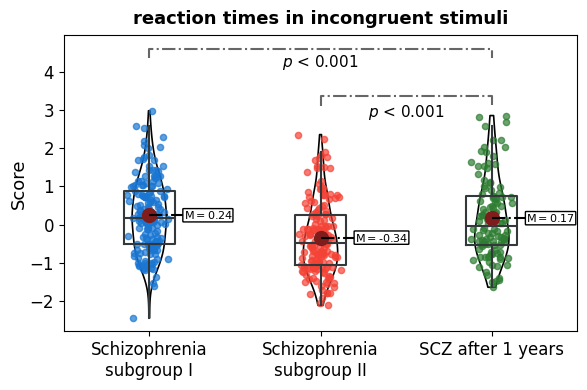



stroop interference effect的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B         t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year  2.921779   0.012    0.376
1   Healthy control      SCZ baseline  1.959310   0.077    0.218
2  SCZ after 1 year      SCZ baseline -1.366401   0.173   -0.171


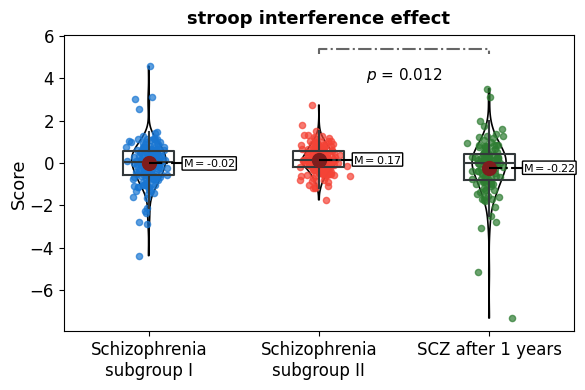



accuracy in Nogo trials的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B         t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year  4.081380   0.000    0.502
1   Healthy control      SCZ baseline  2.903418   0.006    0.321
2  SCZ after 1 year      SCZ baseline -1.439296   0.151   -0.177


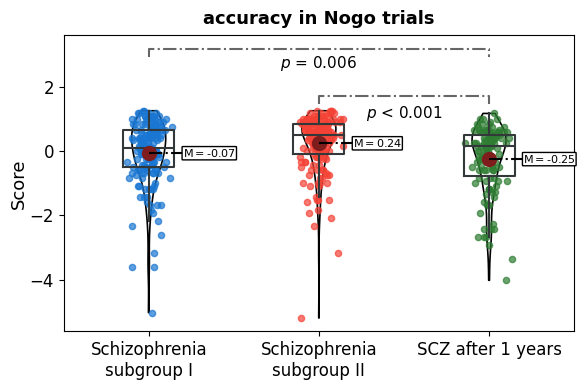



accuracy in 1,750 ms的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B         t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year  9.437976     0.0    1.183
1   Healthy control      SCZ baseline  6.011219     0.0    0.665
2  SCZ after 1 year      SCZ baseline -4.482172     0.0   -0.558


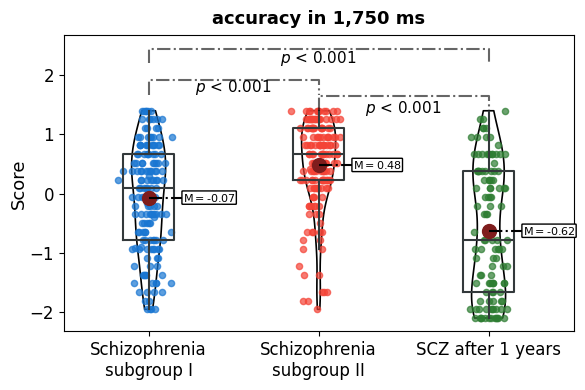



accuracy in 750 ms的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B         t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year  8.336468   0.000    1.046
1   Healthy control      SCZ baseline  5.658641   0.000    0.626
2  SCZ after 1 year      SCZ baseline -3.377756   0.001   -0.418


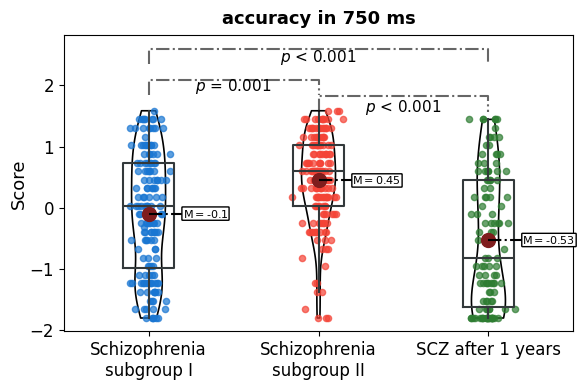



span in digit span backward task的效应量 (Group A, Group B, T, p-corr, cohen-d):
            Group A           Group B          t  p-corr  cohen-d
0   Healthy control  SCZ after 1 year  11.480259     0.0    1.285
1   Healthy control      SCZ baseline   4.833816     0.0    0.531
2  SCZ after 1 year      SCZ baseline  -7.603273     0.0   -0.886


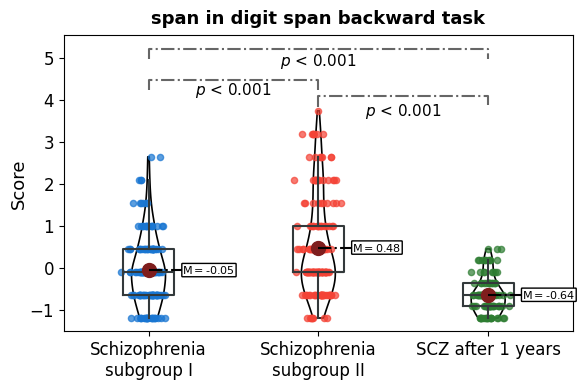

In [5]:
import pandas as pd
import pingouin as pg
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os

# 读取数据
data = pd.read_excel('./raw data/after preprocessing+血液和临床.xlsx', sheet_name='Sheet1')

# 替换Group中的数值为描述性标签
data['Group'] = data['Group'].replace({1: 'SCZ baseline', 2: 'Healthy control', 3: 'SCZ after 1 year'})

# 创建一个虚拟的被试变量
data['Subject'] = range(1, len(data) + 1)

# 定义自变量、因变量和协变量
independent_var = 'Group'  # 组别变量名
dependent_vars = ['reaction times in incongruent stimuli', 'stroop interference effect', 
                      'accuracy in Nogo trials', 'Switching cost', 
                      'accuracy in 1,750 ms', 'accuracy in 750 ms', 
                      'span in digit span backward task']
covariates_cont = ['RPM', 'SES', 'Age', 'Education years', 'BMI']  # 连续协变量
socio_demo_vars_cat = ['Gender', 'Ethnic', 'Residence', 'Only child', 'Smoking status',
                       'Alcohol consumption', 'Employed', 'Marital status']  # 分类协变量



# One-Hot编码社会人口学分类变量
data = pd.get_dummies(data, columns=socio_demo_vars_cat, drop_first=True)

# 将虚拟变量显式转换为数值型
for var in [col for col in data.columns if any(v in col for v in socio_demo_vars_cat)]:
    data[var] = data[var].astype(float)

# 更新协变量列表,包括连续型协变量和虚拟变量
covariates = covariates_cont + [col for col in data.columns if any(var in col for var in socio_demo_vars_cat)]

# 对因变量进行标准化
scaler = StandardScaler()
data[dependent_vars] = scaler.fit_transform(data[dependent_vars])

# 混合设计方差分析 (Mixed ANOVA)
results_mixed_anova = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    for var in dependent_vars:
        # 将数据从wide格式转换为long格式
        melted_data = pd.melt(data, id_vars=['Subject', independent_var] + covariates, value_vars=[var], var_name='Measure', value_name='Score')
        # 执行混合设计方差分析
        anova = pg.mixed_anova(dv='Score', between=independent_var, within='Measure', subject='Subject', data=melted_data)
        results_mixed_anova.append({
            'Variable': var,
            'F': anova.loc[anova['Source'] == independent_var, 'F'].values[0],
            'p-unc': anova.loc[anova['Source'] == independent_var, 'p-unc'].values[0],
            'eta_sq': anova.loc[anova['Source'] == independent_var, 'np2'].values[0]  # Effect size
        })

# 多重比较校正
results_mixed_anova_df = pd.DataFrame(results_mixed_anova)
results_mixed_anova_df['p-corr'] = multipletests(results_mixed_anova_df['p-unc'], method='fdr_bh')[1]
results_mixed_anova_df['p-corr'] = results_mixed_anova_df['p-corr'].round(3)

# 输出校正后的p值、统计值和效应量
print("\n校正后的p值、统计值和效应量:")
print(results_mixed_anova_df[['Variable', 'F', 'p-corr', 'eta_sq']])


# 定义Cohen's d效应量计算函数
def compute_cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    pooled_std = np.sqrt(((group1.std() ** 2) + (group2.std() ** 2)) / 2)
    return diff / pooled_std

# 事后多重比较 (基于调整后的数据) 使用 BH FDR 校正
post_hoc_results = []
cohen_d_results = []

# 定义颜色常量
BG_WHITE = '#FFFFFF'
BLACK = '#000000'
GREY_DARK = '#33393B'
RED_DARK = '#7F1D1D'

# 设置颜色比例尺
COLOR_SCALE = ['#1976D2', '#F44336', '#2E7D32']

# 设置位置常量
POSITIONS = [0, 1, 2]

output_folder = 'output_plots'
os.makedirs(output_folder, exist_ok=True)

for var in dependent_vars:
    if results_mixed_anova_df.loc[results_mixed_anova_df['Variable'] == var, 'p-unc'].values[0] < 0.05:
        # 将数据从wide格式转换为long格式
        melted_data = pd.melt(data, id_vars=['Subject', independent_var], value_vars=[var], var_name='Measure', value_name='Score')
        post_hoc = pg.pairwise_tests(dv='Score', between=independent_var, data=melted_data, padjust='fdr_bh', effsize='cohen')
        post_hoc['p-unc'] = post_hoc['p-unc'].round(3)
        post_hoc['p-corr'] = post_hoc['p-corr'].round(3)
        
        # 手动计算Cohen's d效应量
        effect_sizes = []
        for idx, row in post_hoc.iterrows():
            group1 = data[data[independent_var] == row['A']][var]
            group2 = data[data[independent_var] == row['B']][var]
            cohen_d = compute_cohens_d(group1, group2)
            effect_sizes.append({'Group A': row['A'], 'Group B': row['B'], 't': row['T'], 'p-corr': row['p-corr'], 'cohen-d': round(cohen_d, 3)})
            
            # 提取SCZ after 1 year与SCZ baseline和Healthy control的Cohen's d
            if (row['A'] == 'SCZ after 1 year' and row['B'] in ['SCZ baseline', 'Healthy control']) or \
               (row['B'] == 'SCZ after 1 year' and row['A'] in ['SCZ baseline', 'Healthy control']):
                cohen_d_results.append({'Variable': var, 'Group A': row['A'], 'Group B': row['B'], 'cohen-d': round(cohen_d, 3)})

        effect_size_df = pd.DataFrame(effect_sizes)
        print(f"\n{var}的效应量 (Group A, Group B, T, p-corr, cohen-d):")
        print(effect_size_df[['Group A', 'Group B', 't', 'p-corr', 'cohen-d']])
        
        # 绘制箱线图和小提琴图
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # Layout settings
        fig.patch.set_facecolor(BG_WHITE)
        ax.set_facecolor(BG_WHITE)
        
        # 获取三组数据
        group1_data = data[data[independent_var] == 'SCZ baseline'][var]
        group2_data = data[data[independent_var] == 'Healthy control'][var]
        group3_data = data[data[independent_var] == 'SCZ after 1 year'][var]
        
        # Violin plot
        y_data = [group1_data, group2_data, group3_data]
        violins = ax.violinplot(
            y_data, 
            positions=POSITIONS,
            widths=0.2,
            bw_method="silverman",
            showmeans=False, 
            showmedians=False,
            showextrema=False
        )
        
        for pc in violins["bodies"]:
            pc.set_facecolor("none")
            pc.set_edgecolor(BLACK)
            pc.set_linewidth(1.2)
            pc.set_alpha(1)

        # Box plot properties
        medianprops = dict(
            linewidth=1.5, 
            color=GREY_DARK,
            solid_capstyle="butt"
        )
        boxprops = dict(
            linewidth=1.5, 
            color=GREY_DARK
        )
        
        ax.boxplot(
            y_data,
            positions=POSITIONS, 
            showfliers=False,  
            showcaps=False,    
            medianprops=medianprops,
            whiskerprops=boxprops,
            boxprops=boxprops
        )
        
        # Jittered scatter plot
        x_jittered = [np.random.normal(pos, 0.05, size=len(data)) for pos, data in zip(POSITIONS, y_data)]
        for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
            ax.scatter(x, y, s=20, color=color, alpha=0.7)
            
        means = [y.mean() for y in y_data]
        for i, mean in enumerate(means):
            # Dot representing the mean
            ax.scatter(i, mean, s=100, color=RED_DARK, zorder=3)
            
            # Line connecting mean value and its label
            ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
            
            ax.text(
                i + 0.2,
                mean,
                r"${\rm{M}} = $" + str(round(mean, 2)),
                fontsize=8,
                va="center",
                bbox = dict(
                    facecolor="white",
                    boxstyle="round",
                    pad=0.06
                ),
                zorder=8 
            )

        # Significance lines and labels
        tick_len = 0.25
        
        p_corrected = post_hoc['p-corr'].values

        for i, (p, p_orig) in enumerate(zip(p_corrected, post_hoc['p-unc'].values)):
            if p_orig < 0.05:
                if i == 0:
                    ax.plot(
                        [1, 1, 2, 2], 
                        [
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()) - tick_len, 
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()) - tick_len
                        ], 
                        linestyle='-.', color='black', alpha=0.6
                    )
                    
                    label3 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(1.5, data[var].max() - 0.09 * (data[var].max() - data[var].min()) + pad, label3, fontsize=11, va="bottom", ha="center")
                elif i == 1:
                    ax.plot(
                        [0, 0, 2, 2], 
                        [
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()) - tick_len, 
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()) - tick_len
                        ], 
                        linestyle='-.', color='black', alpha=0.6
                    )
                    
                    label2 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(1, data[var].max() + 0.15 * (data[var].max() - data[var].min()) + pad, label2, fontsize=11, va="bottom", ha="center")
                elif i == 2:
                    ax.plot(
                        [0, 0, 1, 1], 
                        [
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()) - tick_len, 
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()), 
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()) - tick_len
                        ], 
                        linestyle='-.', color='black', alpha=0.6
                    )
                    
                    label1 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(0.5, data[var].max() + 0.01 * (data[var].max() - data[var].min()) + pad, label1, fontsize=11, va="bottom", ha="center")
        
        # Add title and labels
        title = var.replace("_", " ")
        ax.set_title(f"{title}", fontsize=13, fontweight="bold", pad=8)  
        ax.set_ylabel(f"Score", fontsize=13, labelpad=1)
        ax.set_xticks(POSITIONS)
        ax.set_xticklabels(['Schizophrenia\nsubgroup I', 'Schizophrenia\nsubgroup II', 'SCZ after 1 years'])
        
        # Set axis label size
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
        # Save figure
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f"{var}_plot.jpg"), dpi=1200)
        
        # Show figure
        plt.show()
        
        print()

In [9]:
import pandas as pd
import numpy as np

# 读取数据
data = pd.read_excel('./raw data/after preprocessing+血液和临床.xlsx', sheet_name='Sheet1')

# 替换Group中的数值为描述性标签
data['Group'] = data['Group'].replace({1: 'SCZ baseline', 2: 'Healthy control', 3: 'SCZ after 1 year'})

# 创建一个虚拟的被试变量
data['Subject'] = range(1, len(data) + 1)

# 定义自变量和因变量
independent_var = 'Group'
dependent_vars = [
    'reaction times in incongruent stimuli', 
    'stroop interference effect', 
    'accuracy in Nogo trials', 
    'Switching cost', 
    'accuracy in 1,750 ms', 
    'accuracy in 750 ms', 
    'span in digit span backward task'
]

# 计算均值和标准差
for var in dependent_vars:
    mean_std = data.groupby('Group')[var].agg(['mean', 'std']).reset_index()
    mean_std['mean'] = mean_std['mean'].round(2)
    mean_std['std'] = mean_std['std'].round(2)
    mean_std['mean ± std'] = mean_std.apply(lambda row: f"{row['mean']} ± {row['std']}", axis=1)
    
    print(f"{var} 的均值±标准差：")
    print(mean_std[['Group', 'mean ± std']])
    print("\n")

reaction times in incongruent stimuli 的均值±标准差：
              Group       mean ± std
0   Healthy control  663.61 ± 149.02
1  SCZ after 1 year  745.04 ± 165.47
2      SCZ baseline  757.24 ± 152.37


stroop interference effect 的均值±标准差：
              Group      mean ± std
0   Healthy control   -7.04 ± 44.23
1  SCZ after 1 year   -34.9 ± 95.14
2      SCZ baseline  -20.33 ± 74.22


accuracy in Nogo trials 的均值±标准差：
              Group   mean ± std
0   Healthy control  0.88 ± 0.11
1  SCZ after 1 year  0.82 ± 0.13
2      SCZ baseline  0.84 ± 0.12


Switching cost 的均值±标准差：
              Group        mean ± std
0   Healthy control   198.95 ± 238.37
1  SCZ after 1 year  381.79 ± 1343.18
2      SCZ baseline   305.19 ± 295.26


accuracy in 1,750 ms 的均值±标准差：
              Group   mean ± std
0   Healthy control  0.74 ± 0.21
1  SCZ after 1 year  0.42 ± 0.31
2      SCZ baseline  0.58 ± 0.26


accuracy in 750 ms 的均值±标准差：
              Group   mean ± std
0   Healthy control  0.66 ± 0.22
1  SCZ after 1 yea